In [16]:
from dataclasses import dataclass
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import v2

Now that the libraries used (so far) are imported, it's time to construct the architecture for our variational autoencoder. The point is basically that a datapoint, which can also be an image, is encoded into a small-dimensional space, which contains enough information to retrieve the original data point.

We build a new model using the nn.Module class

In [17]:
def train(model, dataloader, optimizer, prev_updates):
    
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass. Here, every node gets a value and gradient.
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   
        optimizer.step()  
        
    return prev_updates + len(dataloader)

def test(model, dataloader):
    
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

In [109]:
@dataclass
class VariationalAutoEncoderOutput:
    """Datastorage of the VAE class"""
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VariationalAutoEncoder(nn.Module):
    """"""

    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Linear(32, 2*latent_dim)       
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32) ,
            nn.SiLU(),
            nn.Linear(32, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

        self.softplus = nn.Softplus()

    def encode(self, x, eps: float=1e-6):
        """Method applying the encoder"""
        x = self.encoder(x)
        mean, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mean, scale_tril=scale_tril)

    def decode(self, z):
        """Method applying the decoder"""
        return self.decoder(z)
        
    def reparameterize(self, dist):
        """..."""
        return dist.rsample()
        
    def forward(self, x, compute_loss: bool = True):
        """Performing the forward pass"""

        dist = self.encode(x)
        z = self.reparameterize(dist)
        reconstruct_x = self.decode(z)

        if not compute_loss:
            return VariationalAutoEncoderOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=reconstruct_x,
            loss=None,
            loss_recon=None,
            loss_kl=None)
        
        std_normal = torch.distributions.MultivariateNormal(torch.zeros_like(z, device=z.device),
                                                            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1))

        loss_recon = F.binary_cross_entropy(reconstruct_x, x, reduction="none").sum(-1).mean()
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        # Try to minimize the reconstruction loss, as well as the divergence between z and the standard normal
        # The last enforces the z to be multivariate normals numbers. AMAZING!
        loss = loss_recon + loss_kl 
        
        return VariationalAutoEncoderOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=reconstruct_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl)

In [110]:
batch_size = 128

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5)])

# Download and load the training and testing data
train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [111]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 3
latent_dim = 16

device = torch.device('cpu')
model = VariationalAutoEncoder(input_dim=784, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [112]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates)
    test(model, test_loader)

Epoch 1/3


TypeError: train() missing 1 required positional argument: 'epoch'

In [30]:
loc = torch.zeros(16)
scale = torch.ones(16)
mvrGenerator = torch.distributions.MultivariateNormal(loc, scale_tril=torch.diag(scale))

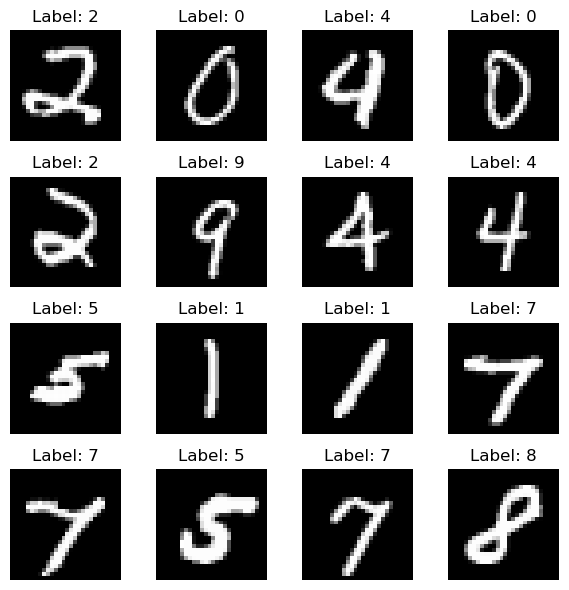

In [31]:
# Select 16 random images
num_images = 16
indices = torch.randperm(len(train_data))[:num_images]
images, labels = zip(*[train_data[i] for i in indices])

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, (image, label) in enumerate(zip(images, labels)):
    ax = axes[i // 4, i % 4]
    ax.imshow(image.numpy().reshape(28, 28), cmap='gray')  
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Testing: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


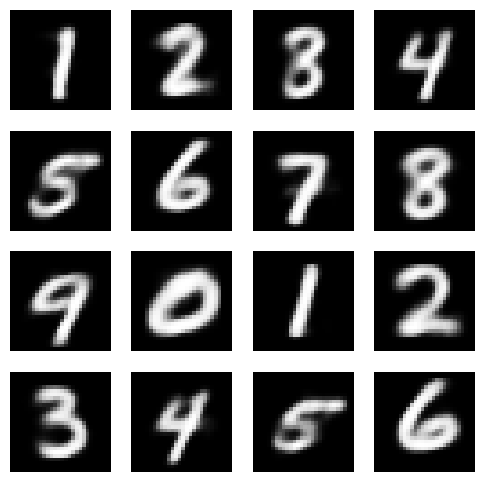

In [32]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
test_recon_loss = 0
test_kl_loss = 0
   
with torch.no_grad():
      for data, target in tqdm(test_loader, desc='Testing'):
        data = data.to(device)
        data = data.view(data.size(0), -1)  # Flatten the data
        output = model(data, compute_loss=True)  # Forward pass
            
            
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, image in enumerate(output.x_recon):
    ax = axes[i // 4, i % 4]
    ax.imshow(image.reshape(28, 28), cmap='gray') 
    ax.axis('off')

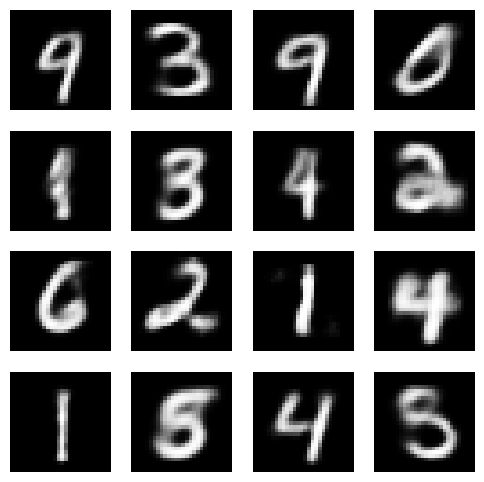

In [33]:
z_values = mvrGenerator.sample(sample_shape=torch.Size([32]))
sampled_images = model.decoder(z_values).detach().numpy()[0:16]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, image in enumerate(sampled_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(image.reshape(28, 28), cmap='gray') 
    ax.axis('off')

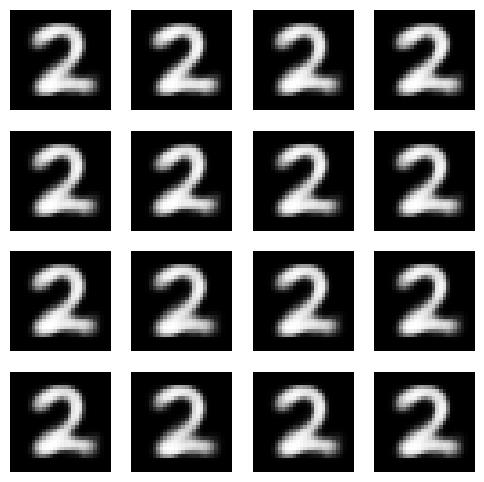

In [87]:
img = data[11,:]
imgs = torch.stack([img] * 16)
imgs_encoded = model.forward(imgs).x_recon.detach().numpy()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, image in enumerate(imgs_encoded):
    ax = axes[i // 4, i % 4]
    ax.imshow(image.reshape(28, 28), cmap='gray') 
    ax.axis('off')

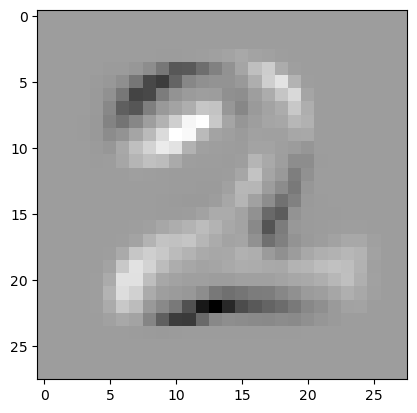

In [88]:
plt.imshow((imgs_encoded[12,:] - imgs_encoded[14,:]).reshape(28, 28), cmap='gray') 

(-1.0, 5.0)

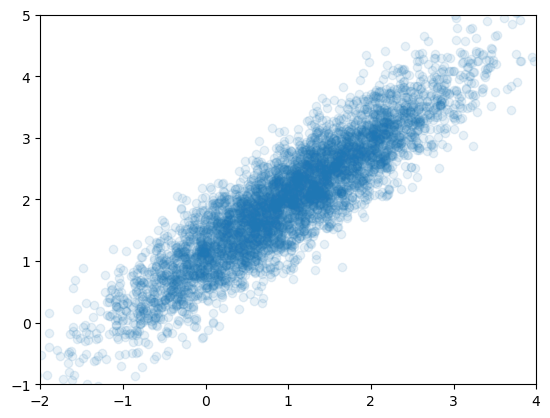

In [113]:
import numpy as np
import matplotlib.pyplot as plt 

def generate_multivariate_normal_samples(mean, cov, num_samples):
    L = np.linalg.cholesky(cov)
    z = np.random.normal(size=(num_samples, len(mean)))
    samples = mean + np.dot(z, L.T)
    return samples

r = 0.9
mean = np.array([1.0, 2.0])
cov = np.array([[1.0, r], 
                [r, 1.0]])
num_samples = 5000

samples = generate_multivariate_normal_samples(mean, cov, num_samples)
samples_test = generate_multivariate_normal_samples(mean, cov, num_samples)

plt.scatter(samples[:,0], samples[:,1], alpha=0.1)
plt.xlim([-2, 4])
plt.ylim([-1, 5])

[Irrelevant] Use the Moore-Penrose inverse for linear models:
U, V, D as a SVD of A. Then the system of equations Ax=Y is solved by $A^+=VD^+U^T$: $x=A^+y$.
This solution is the MSE, i.e., $||Ax-y||_2$ is minimised.

We check if an autoencoder can learn corrlation structures. We do this by encoding all the data into a uncorrelated multivariate gaussian distribution. Essentially we make an encoder function e() and decoder function d() such that d(e(x))~=x, such that e(x)~mvrnorm(0,I)

First we generate some random correlation matrix to sample variables

In [114]:
def random_correlation_matrix(dimension, seed=None):
    A = np.random.randn(dimension, dimension)
    cov = np.dot(A, A.T)
    d = np.sqrt(np.diag(cov))
    correlation_matrix = cov / np.outer(d, d)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

In [168]:
@dataclass
class VariationalAutoEncoderOutput:
    """Datastorage of the VariationalAutoEncoder class"""
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VariationalAutoEncoder(nn.Module):
    """"""

    def __init__(self, input_dim):
        super(VariationalAutoEncoder, self).__init__()
       
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2*input_dim),  
            nn.Sigmoid()   
        )

        self.decoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )
        

        self.softplus = nn.Softplus()

    def encode(self, x, eps: float=1e-6):
        """Method applying the encoder"""
        x = self.encoder(x)
        mean, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mean, scale_tril=scale_tril)

    def decode(self, z):
        """Method applying the decoder"""
        return self.decoder(z)
        
    def reparameterize(self, dist):
        """..."""
        return dist.rsample()
        
        
    def forward(self, x, compute_loss: bool = True):
        """Performing the forward pass"""

        dist = self.encode(x)
        z = self.reparameterize(dist)
        reconstruct_x = self.decode(z)

        if not compute_loss:
            return VariationalAutoEncoderOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=reconstruct_x,
            loss=None,
            loss_recon=None,
            loss_kl=None)

        std_normal = torch.distributions.MultivariateNormal(torch.zeros_like(z, device=z.device),
                                                            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1))

        # Use MSE loss instead of binary cross-entropy
        loss_recon = F.mse_loss(reconstruct_x, x, reduction="mean")
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
        loss = loss_recon + 1.5*loss_kl 

        return VariationalAutoEncoderOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=reconstruct_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl)
    
import torch
from tqdm import tqdm

def train(model, data, optimizer, prev_updates, epoch):
    model.train()  # Set the model to training mode

    for batch_idx, batch_data in enumerate(tqdm(data)):
        n_upd = prev_updates + batch_idx
        
        batch_data = batch_data.to(device)
        
        optimizer.zero_grad()
        output = model(batch_data) 
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()
        
    # Print epoch number every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')

    return prev_updates + len(data)

def test(model, data):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for batch_data in tqdm(data, desc='Testing'):
            batch_data = batch_data.to(device)
            
            output = model(batch_data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(data)
    test_recon_loss /= len(data)
    test_kl_loss /= len(data)
    
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    return test_loss

def early_stopping(patience, min_delta=0.001):
    best_loss = None
    counter = 0
    
    def check_early_stop(current_loss):
        nonlocal best_loss, counter
        if best_loss is None:
            best_loss = current_loss
            return False
        elif current_loss < best_loss - min_delta:
            best_loss = current_loss
            counter = 0
            return False
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                return True
            return False

    return check_early_stop

In [165]:
num_samples = 400
dimension = 6

mu = np.zeros(dimension)
correlation_matrix = random_correlation_matrix(dimension)

samples = generate_multivariate_normal_samples(mu, correlation_matrix, num_samples)
samples_test = generate_multivariate_normal_samples(mu, correlation_matrix, num_samples)

samples = torch.from_numpy(samples).float()
samples_test = torch.from_numpy(samples_test).float()

print("Correlation matrix")
print(correlation_matrix)
print("\n Cholesky decomposition of the correlation matrix")
print(np.linalg.cholesky(correlation_matrix))

if np.all(np.linalg.eigvals(correlation_matrix) > 0):
    print("\n All eigenvalues are positive")

Correlation matrix
[[ 1.          0.02053139 -0.00970915 -0.71084474  0.53957492 -0.79295548]
 [ 0.02053139  1.         -0.05058671 -0.12521952  0.25585327 -0.40010122]
 [-0.00970915 -0.05058671  1.         -0.2672197   0.36830222  0.16269286]
 [-0.71084474 -0.12521952 -0.2672197   1.         -0.31618697  0.64841303]
 [ 0.53957492  0.25585327  0.36830222 -0.31618697  1.         -0.54002592]
 [-0.79295548 -0.40010122  0.16269286  0.64841303 -0.54002592  1.        ]]

 Cholesky decomposition of the correlation matrix
[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.02053139  0.99978921  0.          0.          0.          0.        ]
 [-0.00970915 -0.05039799  0.99868202  0.          0.          0.        ]
 [-0.71084474 -0.11064821 -0.28006697  0.63562506  0.          0.        ]
 [ 0.53957492  0.24482665  0.38638906  0.31885381  0.6308364   0.        ]
 [-0.79295548 -0.38390166  0.13582508  0.12634316 -0.1758681   0.3981212 ]]

 All eigenvalues are positi

In [166]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 35
latent_dim = 4

device = torch.device('cpu')
modelAE = VariationalAutoEncoder(input_dim=dimension).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [169]:
prev_updates = 0
stop_checker = early_stopping(patience=10)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(modelAE, samples, optimizer, prev_updates, epoch)
    test_loss = test(modelAE, samples_test)

    if stop_checker(test_loss):
        break

Epoch 1/35


100%|██████████| 400/400 [00:00<00:00, 433.34it/s]


Epoch: 0


Testing: 100%|██████████| 400/400 [00:00<00:00, 1086.64it/s]


====> Test set loss: 2.3755 (BCE: 1.1840, KLD: 0.7944)
Epoch 2/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1148.62it/s]


====> Test set loss: 2.3722 (BCE: 1.1807, KLD: 0.7944)
Epoch 3/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1032.30it/s]


====> Test set loss: 2.3712 (BCE: 1.1796, KLD: 0.7944)
Epoch 4/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1110.88it/s]


====> Test set loss: 2.3660 (BCE: 1.1745, KLD: 0.7944)
Epoch 5/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1106.06it/s]


====> Test set loss: 2.3735 (BCE: 1.1819, KLD: 0.7944)
Epoch 6/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1281.49it/s]


====> Test set loss: 2.3637 (BCE: 1.1721, KLD: 0.7944)
Epoch 7/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1039.55it/s]


====> Test set loss: 2.3755 (BCE: 1.1839, KLD: 0.7944)
Epoch 8/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1149.81it/s]


====> Test set loss: 2.3644 (BCE: 1.1729, KLD: 0.7944)
Epoch 9/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1015.26it/s]


====> Test set loss: 2.3588 (BCE: 1.1673, KLD: 0.7944)
Epoch 10/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1171.89it/s]


====> Test set loss: 2.3688 (BCE: 1.1772, KLD: 0.7944)
Epoch 11/35


100%|██████████| 400/400 [00:00<00:00, 447.34it/s]


Epoch: 10


Testing: 100%|██████████| 400/400 [00:00<00:00, 1043.90it/s]


====> Test set loss: 2.3767 (BCE: 1.1851, KLD: 0.7944)
Epoch 12/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1168.37it/s]


====> Test set loss: 2.3600 (BCE: 1.1684, KLD: 0.7944)
Epoch 13/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1014.62it/s]


====> Test set loss: 2.3722 (BCE: 1.1806, KLD: 0.7944)
Epoch 14/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1146.87it/s]


====> Test set loss: 2.3769 (BCE: 1.1854, KLD: 0.7944)
Epoch 15/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1224.73it/s]


====> Test set loss: 2.3746 (BCE: 1.1831, KLD: 0.7944)
Epoch 16/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1193.31it/s]


====> Test set loss: 2.3714 (BCE: 1.1799, KLD: 0.7944)
Epoch 17/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1181.40it/s]


====> Test set loss: 2.3720 (BCE: 1.1805, KLD: 0.7944)
Epoch 18/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1175.97it/s]


====> Test set loss: 2.3571 (BCE: 1.1656, KLD: 0.7944)
Epoch 19/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1182.76it/s]


====> Test set loss: 2.3666 (BCE: 1.1750, KLD: 0.7944)
Epoch 20/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1146.97it/s]


====> Test set loss: 2.3792 (BCE: 1.1876, KLD: 0.7944)
Epoch 21/35


100%|██████████| 400/400 [00:00<00:00, 430.44it/s]


Epoch: 20


Testing: 100%|██████████| 400/400 [00:00<00:00, 1134.92it/s]


====> Test set loss: 2.3773 (BCE: 1.1857, KLD: 0.7944)
Epoch 22/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1191.58it/s]


====> Test set loss: 2.3552 (BCE: 1.1637, KLD: 0.7944)
Epoch 23/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1195.96it/s]


====> Test set loss: 2.3583 (BCE: 1.1668, KLD: 0.7944)
Epoch 24/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1257.28it/s]


====> Test set loss: 2.3727 (BCE: 1.1812, KLD: 0.7944)
Epoch 25/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1219.98it/s]


====> Test set loss: 2.3632 (BCE: 1.1716, KLD: 0.7944)
Epoch 26/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1172.93it/s]


====> Test set loss: 2.3666 (BCE: 1.1751, KLD: 0.7944)
Epoch 27/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1222.28it/s]


====> Test set loss: 2.3687 (BCE: 1.1771, KLD: 0.7944)
Epoch 28/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1166.69it/s]


====> Test set loss: 2.3740 (BCE: 1.1825, KLD: 0.7944)
Epoch 29/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1194.19it/s]


====> Test set loss: 2.3730 (BCE: 1.1814, KLD: 0.7944)
Epoch 30/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1243.19it/s]


====> Test set loss: 2.3743 (BCE: 1.1827, KLD: 0.7944)
Epoch 31/35


100%|██████████| 400/400 [00:00<00:00, 442.58it/s]


Epoch: 30


Testing: 100%|██████████| 400/400 [00:00<00:00, 1232.99it/s]


====> Test set loss: 2.3605 (BCE: 1.1689, KLD: 0.7944)
Epoch 32/35


Testing: 100%|██████████| 400/400 [00:00<00:00, 1168.49it/s]

====> Test set loss: 2.3670 (BCE: 1.1755, KLD: 0.7944)
Early stopping triggered


In [172]:
z_values = mvrGenerator.sample(sample_shape=torch.Size([dimension]))
z_values.shape

torch.Size([6, 16])